In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# =====================
# Academic Plot Settings
# =====================
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Palatino', 'DejaVu Serif'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'axes.linewidth': 1.2,
    'grid.color': '0.8',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'figure.figsize': (7, 5),
    'figure.autolayout': True,
    'mathtext.fontset': 'stix'
})

# =====================
# MLP Model Definition
# =====================
class ImpedanceEstimator(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)
    
    @staticmethod
    def train_model(X, y, input_dim=1, epochs=1000, lr=0.01):
        model = ImpedanceEstimator(input_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4e}')
                
        return model

# =====================
# Prepare Data
# =====================
# Tissue characteristics data
tissue_data = pd.DataFrame({
    "Tissue": ["Fat", "Liver", "Muscle", "White Matter", "Gray Matter", "CSF", "Air", "Bone (PW)"],
    "T1 Intensity": [260, 500, 870, 780, 920, 2500, 0, 525],
    "Impedance (MRayl)": [1.34, 1.67, 1.68, 1.60, 1.60, 1.50, 0.0004, 1.50]
})

tissue_data = tissue_data.sort_values(by="T1 Intensity").reset_index(drop=True)

# Normalize intensities to [0, 1] range
min_int, max_int = tissue_data['T1 Intensity'].min(), tissue_data['T1 Intensity'].max()
tissue_data['Norm Intensity'] = (tissue_data['T1 Intensity'] - min_int) / (max_int - min_int)

# Create training tensors
X_train = torch.tensor(tissue_data['Norm Intensity'].values.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(tissue_data['Impedance (MRayl)'].values.reshape(-1, 1), dtype=torch.float32)

# Train model
print("Training MLP model...")
model = ImpedanceEstimator.train_model(X_train, y_train)
print("Training complete!")

# =====================
# Generate Prediction Curve
# =====================
x_range = np.linspace(-0.1, 1.1, 500)
x_tensor = torch.tensor(x_range, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_tensor).numpy().flatten()

Training MLP model...
Epoch [100/1000], Loss: 1.8692e-02
Epoch [200/1000], Loss: 2.4092e-03
Epoch [300/1000], Loss: 2.3902e-03
Epoch [400/1000], Loss: 2.3867e-03
Epoch [500/1000], Loss: 2.3863e-03
Epoch [600/1000], Loss: 2.3862e-03
Epoch [700/1000], Loss: 2.3862e-03
Epoch [800/1000], Loss: 2.3862e-03
Epoch [900/1000], Loss: 2.3863e-03
Epoch [1000/1000], Loss: 2.3863e-03
Training complete!


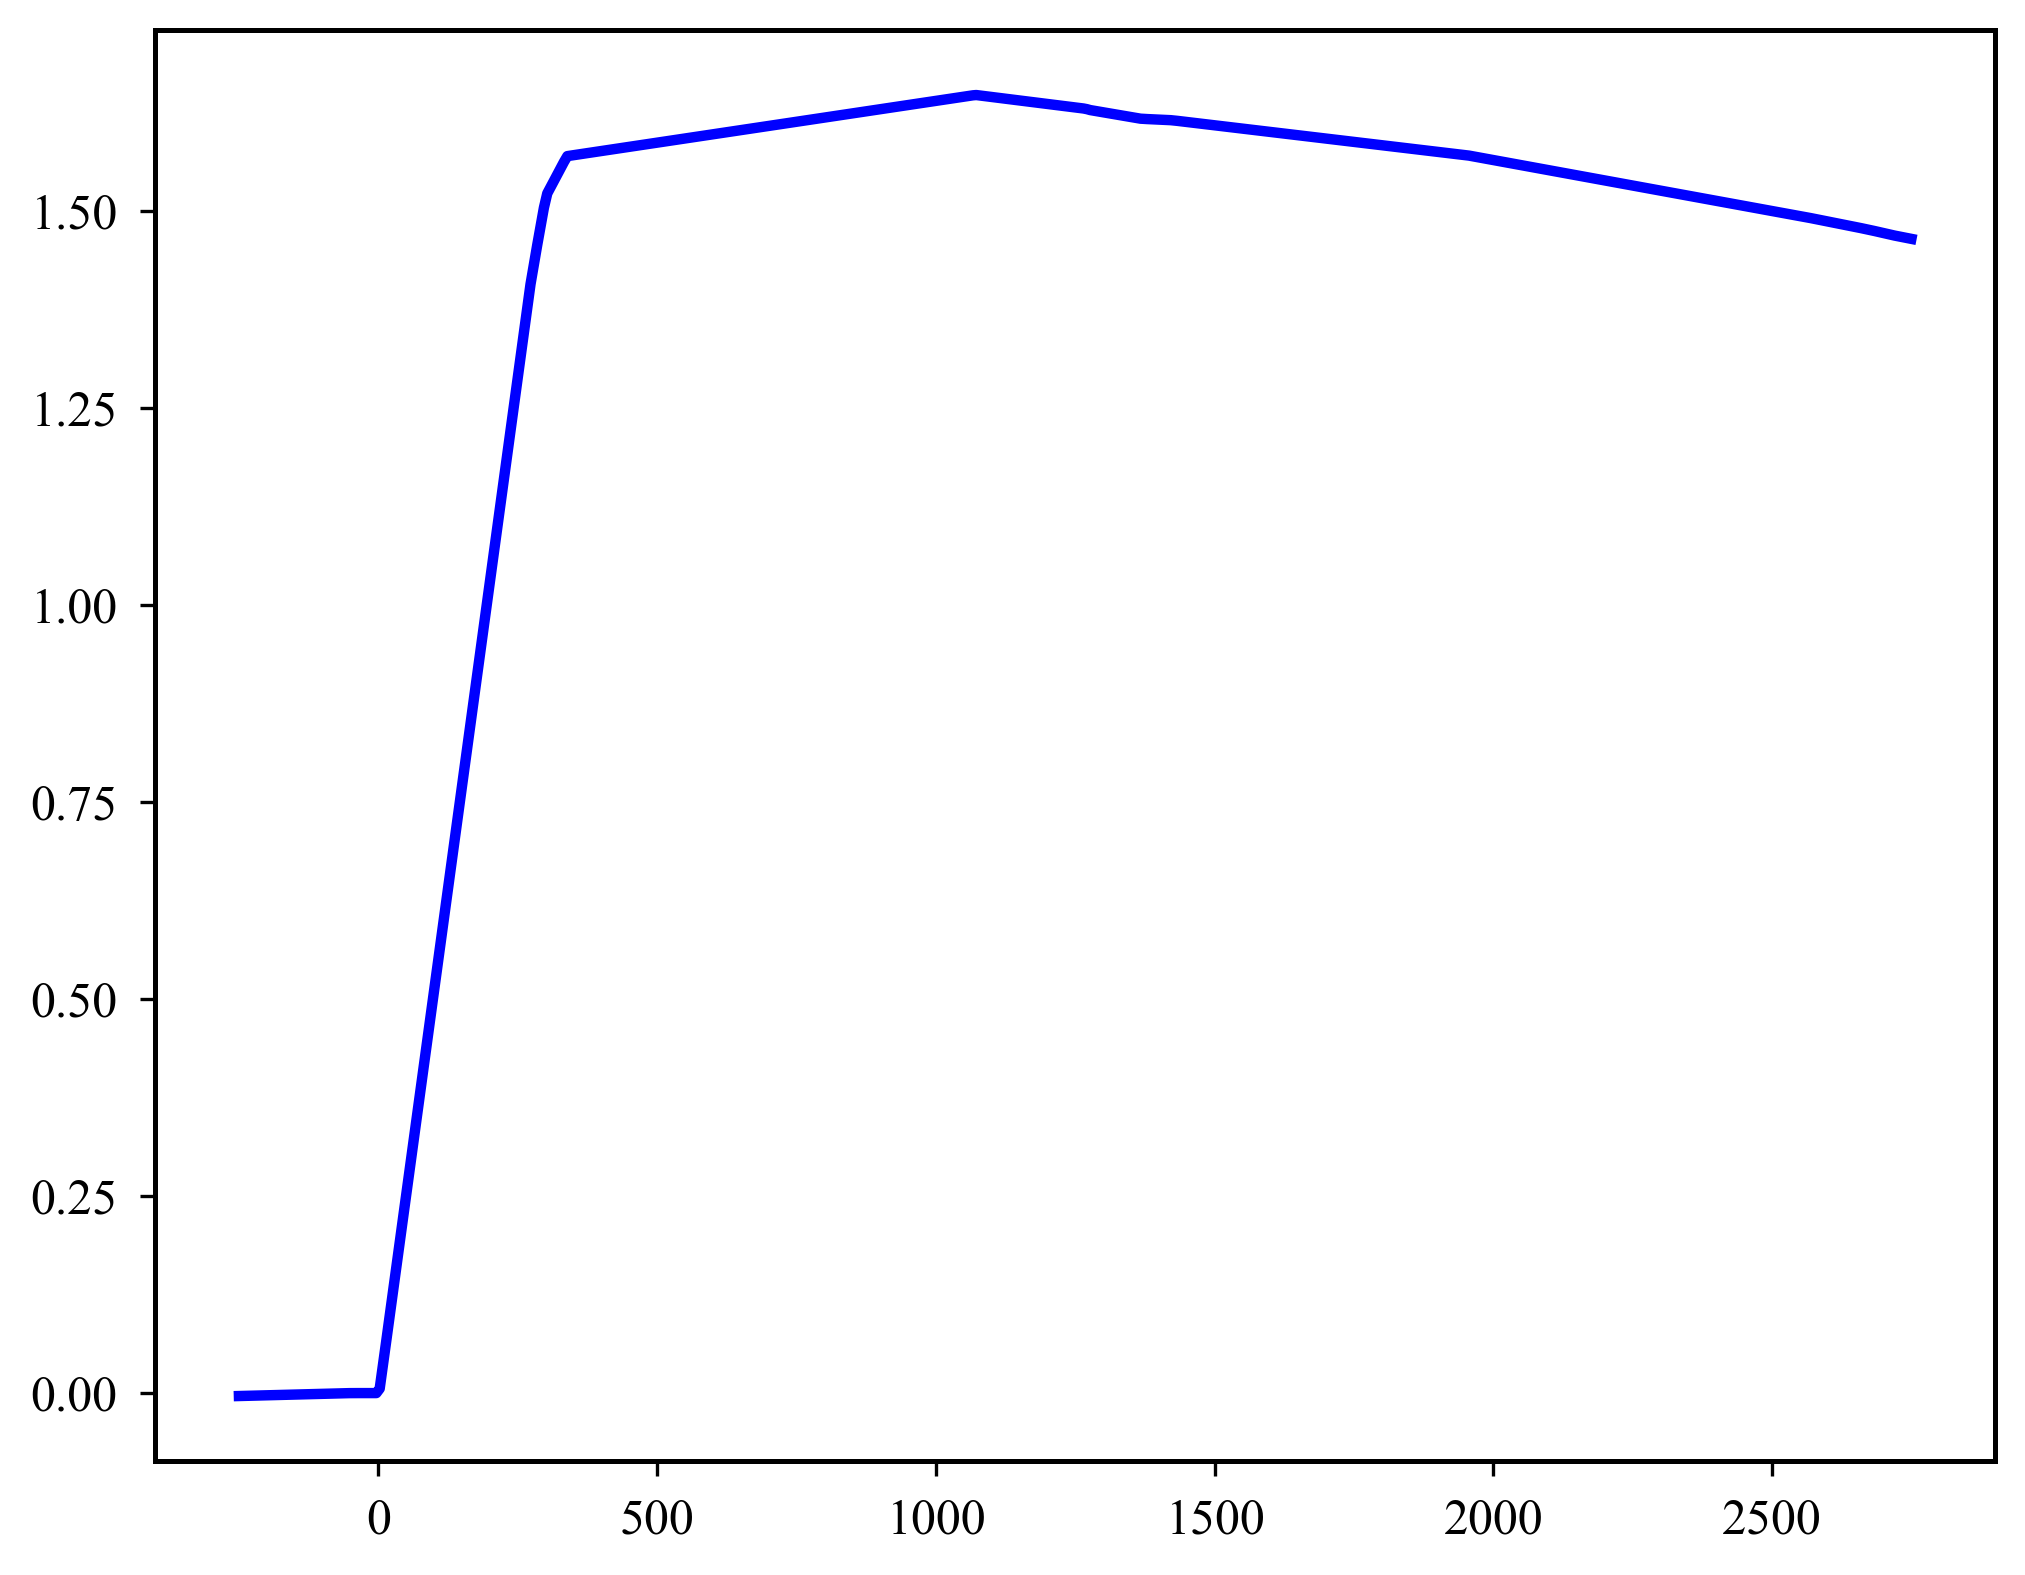

In [26]:
fig, ax = plt.subplots(figsize=(7, 5.5))

x_curve_original = min_int + (x_range) * (max_int - min_int)
ax.plot(x_curve_original, y_pred, 'b-', linewidth=2.5, label='Learned Impedance Mapping', zorder=10)


In [4]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

In [ ]:
t1_file = r"C:\Users\noe\Desktop\MIT\6.8300\project\DiffUS_DifferentiableUltrasoundfromMRI\additional_data\Reuben\Case002-cet1.nii.gz"
iUS_file= r"C:\Users\noe\Desktop\MIT\6.8300\project\DiffUS_DifferentiableUltrasoundfromMRI\additional_data\Reuben\Case002-us.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine

In [27]:
T1_vol_tensor = torch.tensor(T1_vol, dtype=torch.float32)
T1_flat = T1_vol_tensor.flatten().unsqueeze(1)  # shape (N, 1)

with torch.no_grad():
    Z_flat = model(T1_flat).squeeze() * 1e6  # shape (N,)

Z_vol = Z_flat.reshape(T1_vol_tensor.shape)

# Preliminary computations

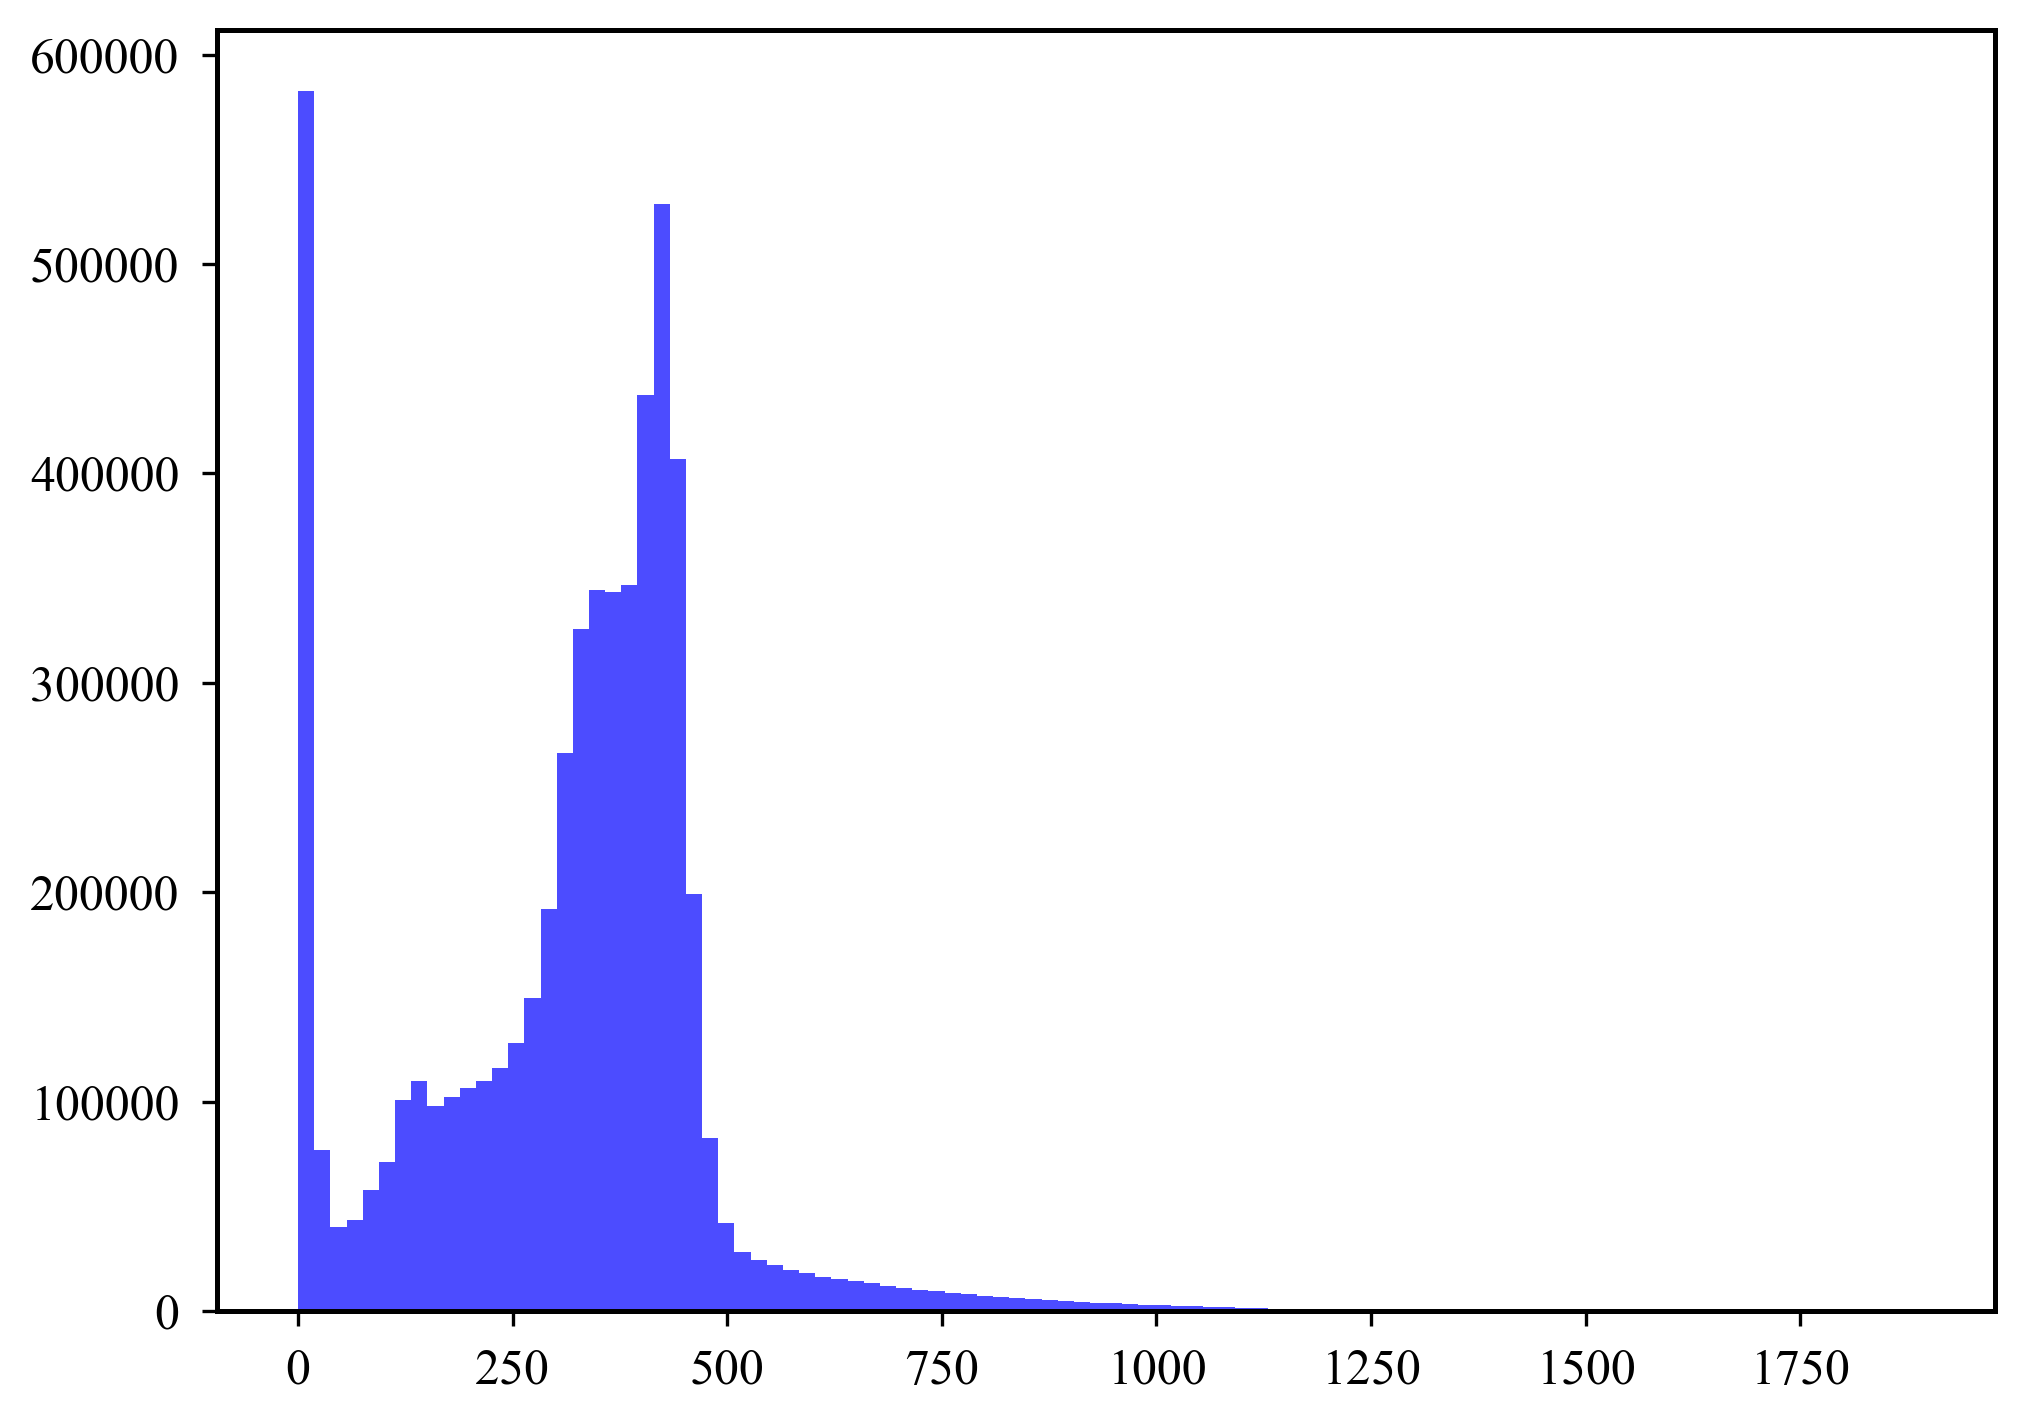

(array([4.90759e+05, 1.58728e+05, 4.10540e+04, 4.21280e+04, 5.38300e+04,
        6.83220e+04, 9.22070e+04, 1.13552e+05, 9.85130e+04, 1.01130e+05,
        1.06495e+05, 1.09414e+05, 1.14677e+05, 1.25133e+05, 1.43890e+05,
        1.82533e+05, 2.50238e+05, 3.18510e+05, 3.43383e+05, 3.45047e+05,
        3.43415e+05, 4.12596e+05, 5.27565e+05, 4.43076e+05, 2.34967e+05,
        9.49880e+04, 4.69160e+04, 2.95260e+04, 2.48800e+04, 2.27130e+04,
        2.02450e+04, 1.82360e+04, 1.67150e+04, 1.56090e+04, 1.45360e+04,
        1.33480e+04, 1.23120e+04, 1.12100e+04, 1.03540e+04, 9.54500e+03,
        8.90100e+03, 8.16600e+03, 7.48300e+03, 6.66400e+03, 6.43400e+03,
        5.77600e+03, 5.23100e+03, 4.82600e+03, 4.34800e+03, 4.10300e+03,
        3.70500e+03, 3.33200e+03, 3.01800e+03, 2.74900e+03, 2.49400e+03,
        2.25000e+03, 2.01700e+03, 1.75200e+03, 1.50500e+03, 1.31400e+03,
        1.03700e+03, 8.71000e+02, 7.22000e+02, 5.88000e+02, 4.65000e+02,
        3.85000e+02, 2.92000e+02, 2.39000e+02, 1.88

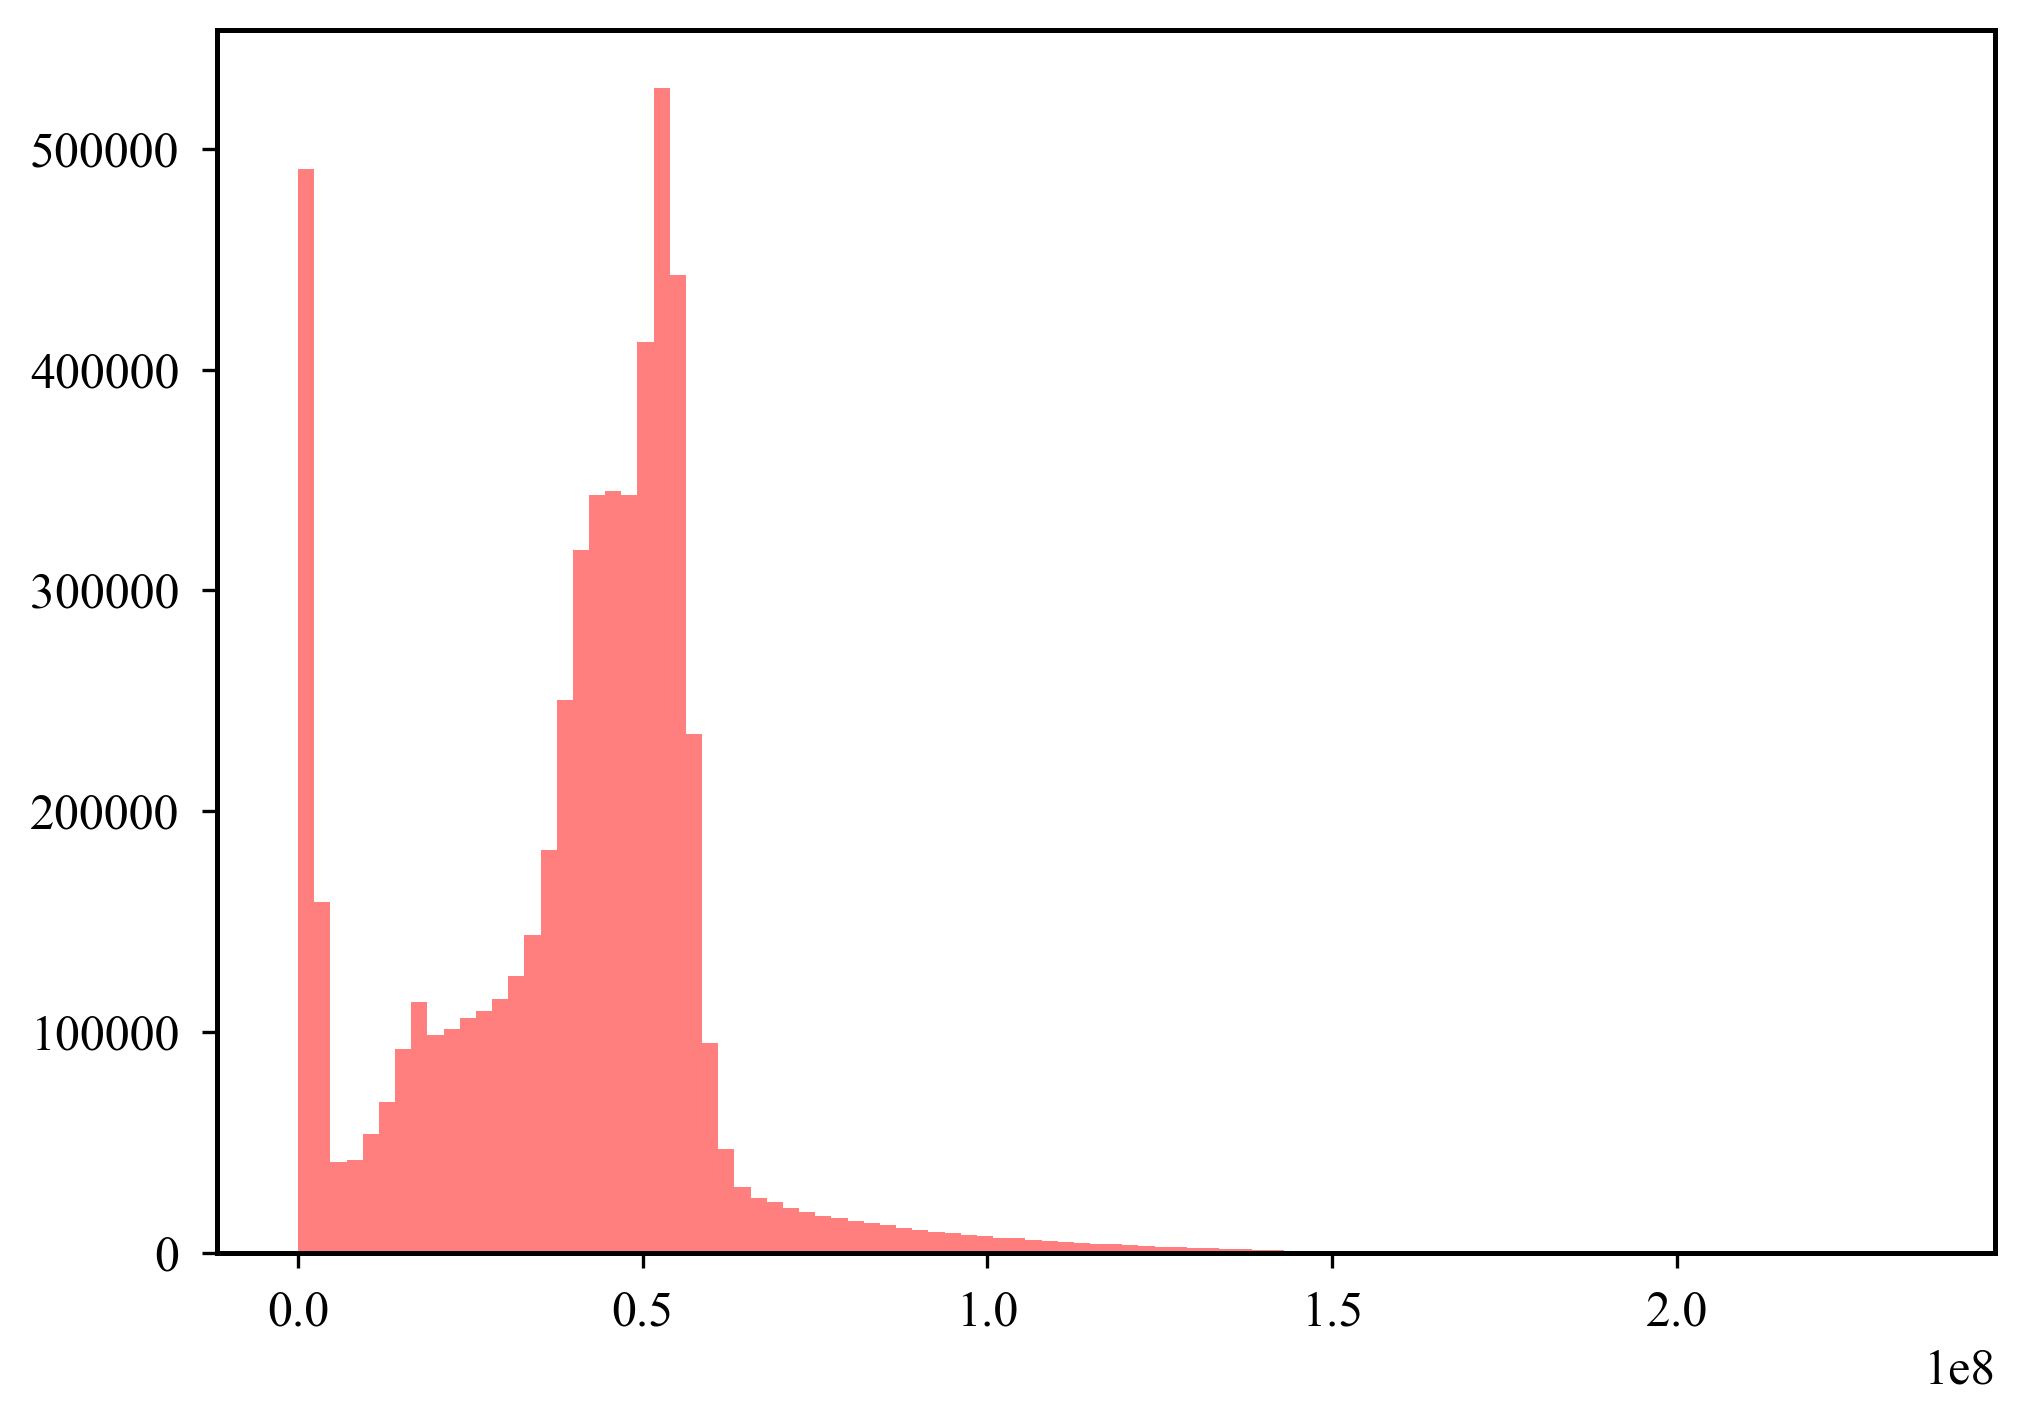

In [31]:
plt.hist(T1_flat, bins=100, color='blue', alpha=0.7)
plt.show()
plt.hist(Z_vol.flatten(), bins=100, color='red', alpha=0.5)

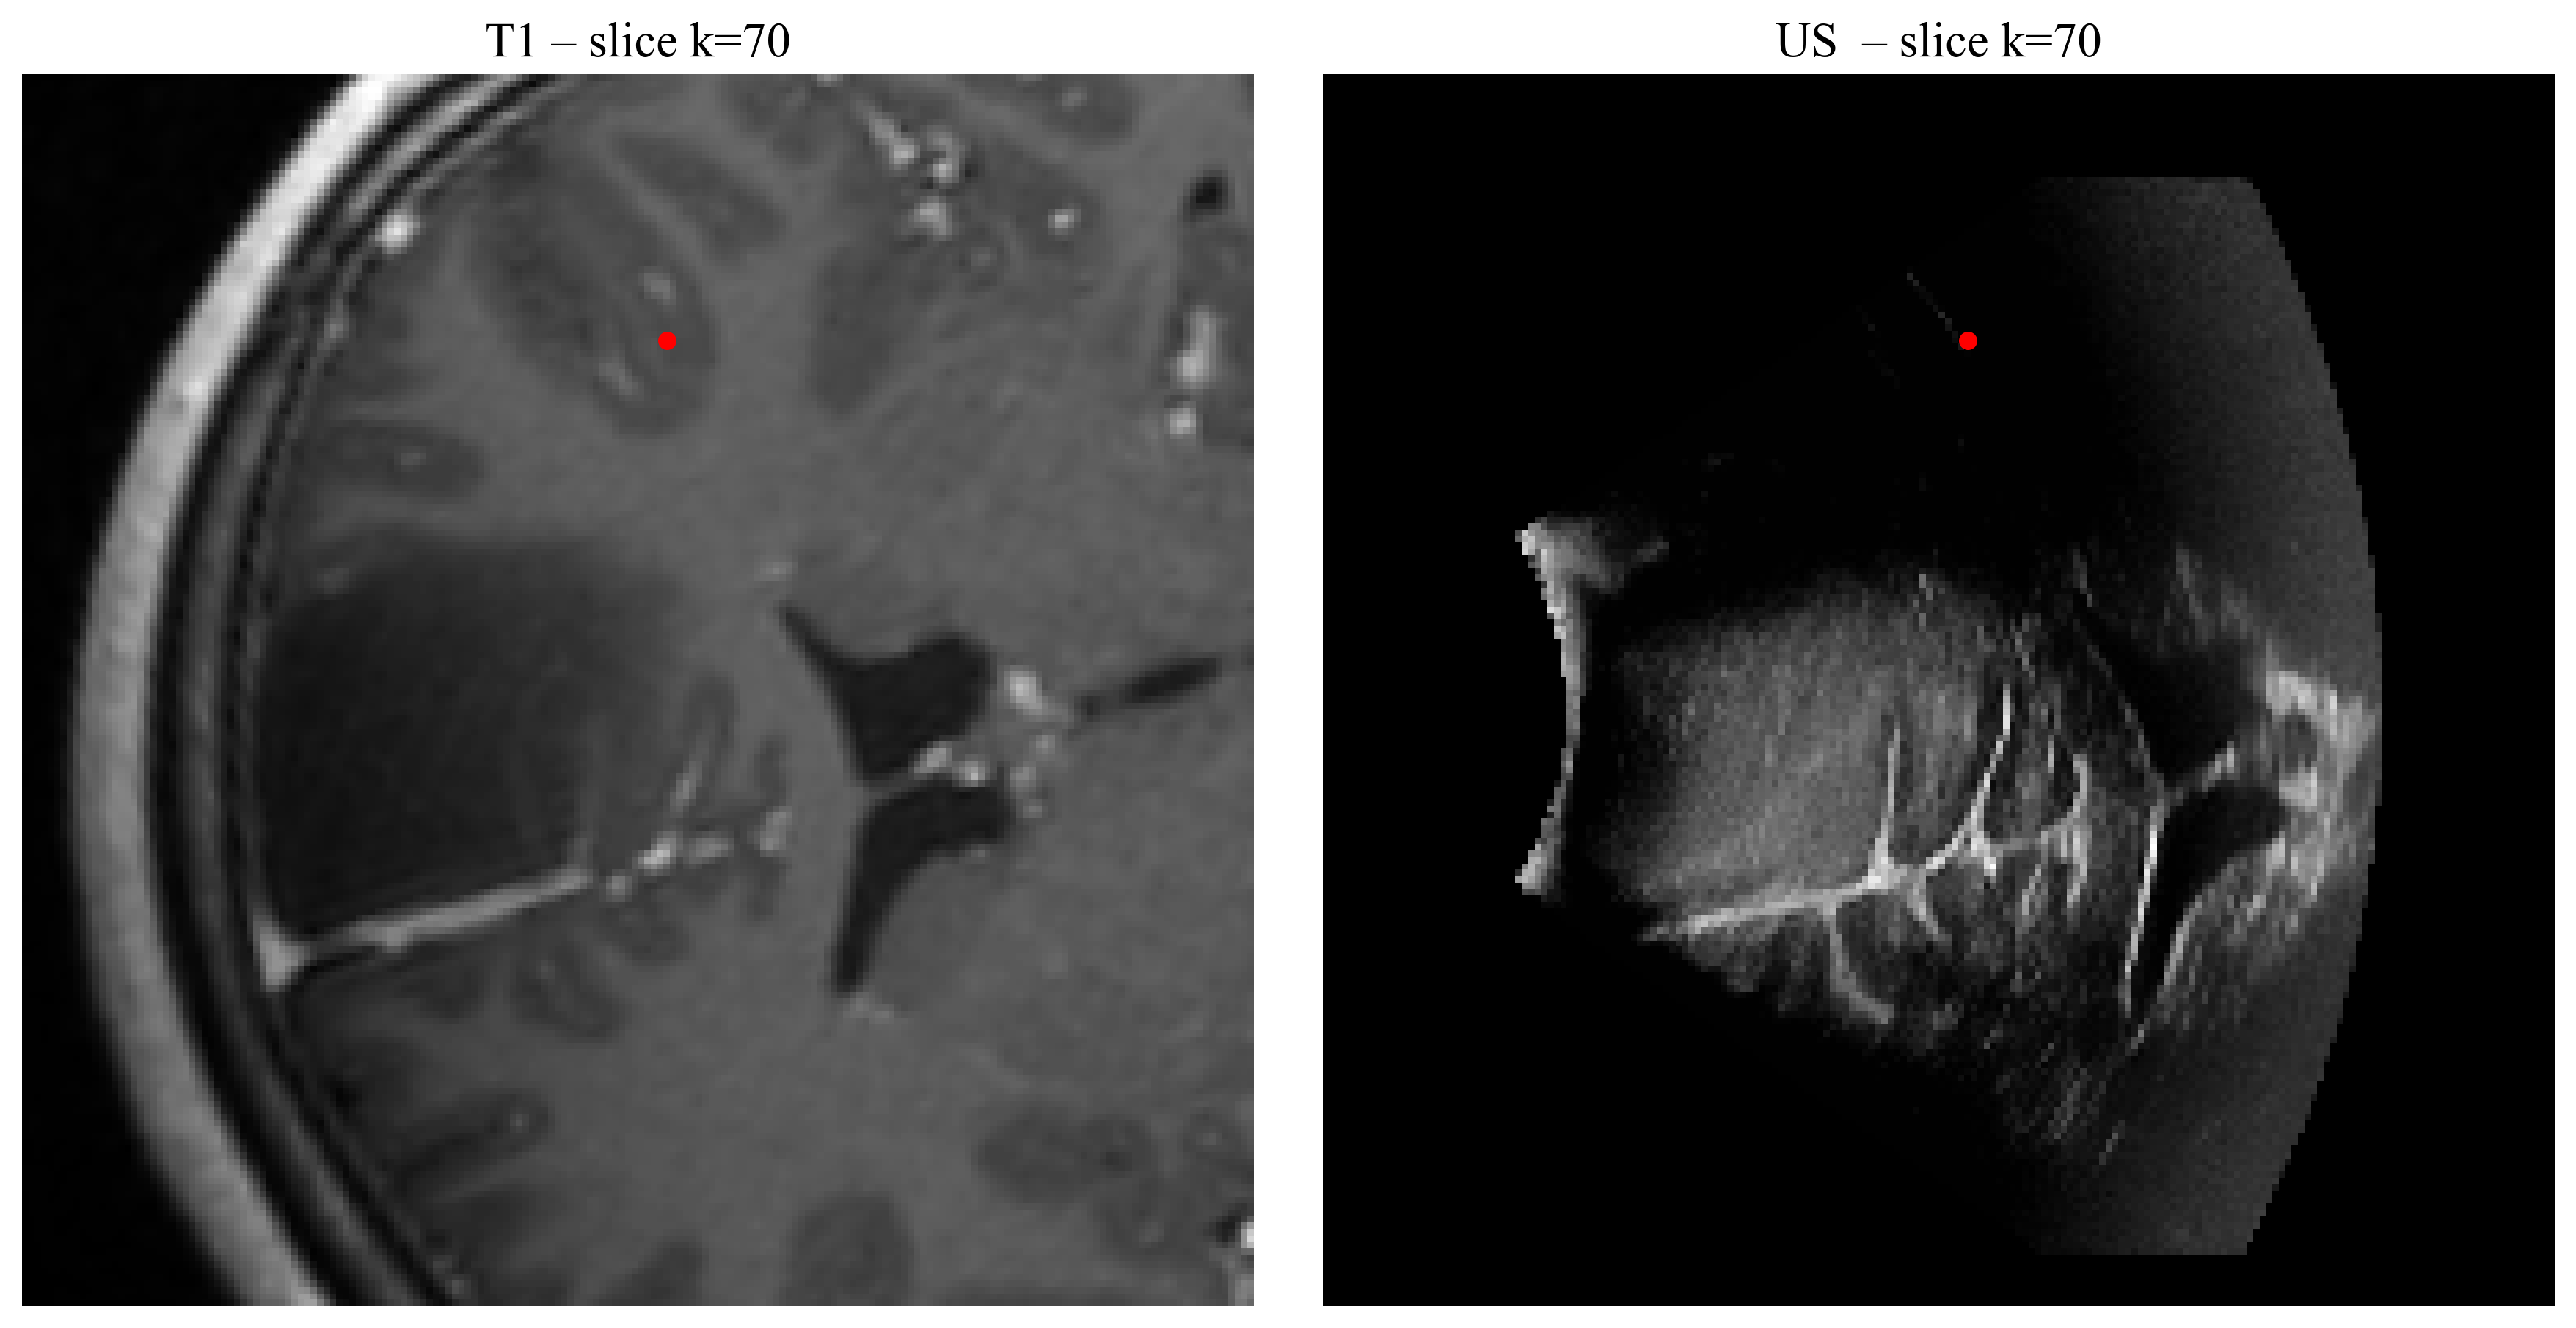

In [8]:
i_mri, j_mri, slice_idx = 150, 100, 70 # Example indices for T1 MRI
us_slice, us_idx = mri_to_us_point(i_mri, j_mri, slice_idx, T1_vol, T1_affine, US_vol, US_affine)
plot_mri_us_aligned(i_mri, j_mri, slice_idx, T1_vol, us_slice, us_idx)

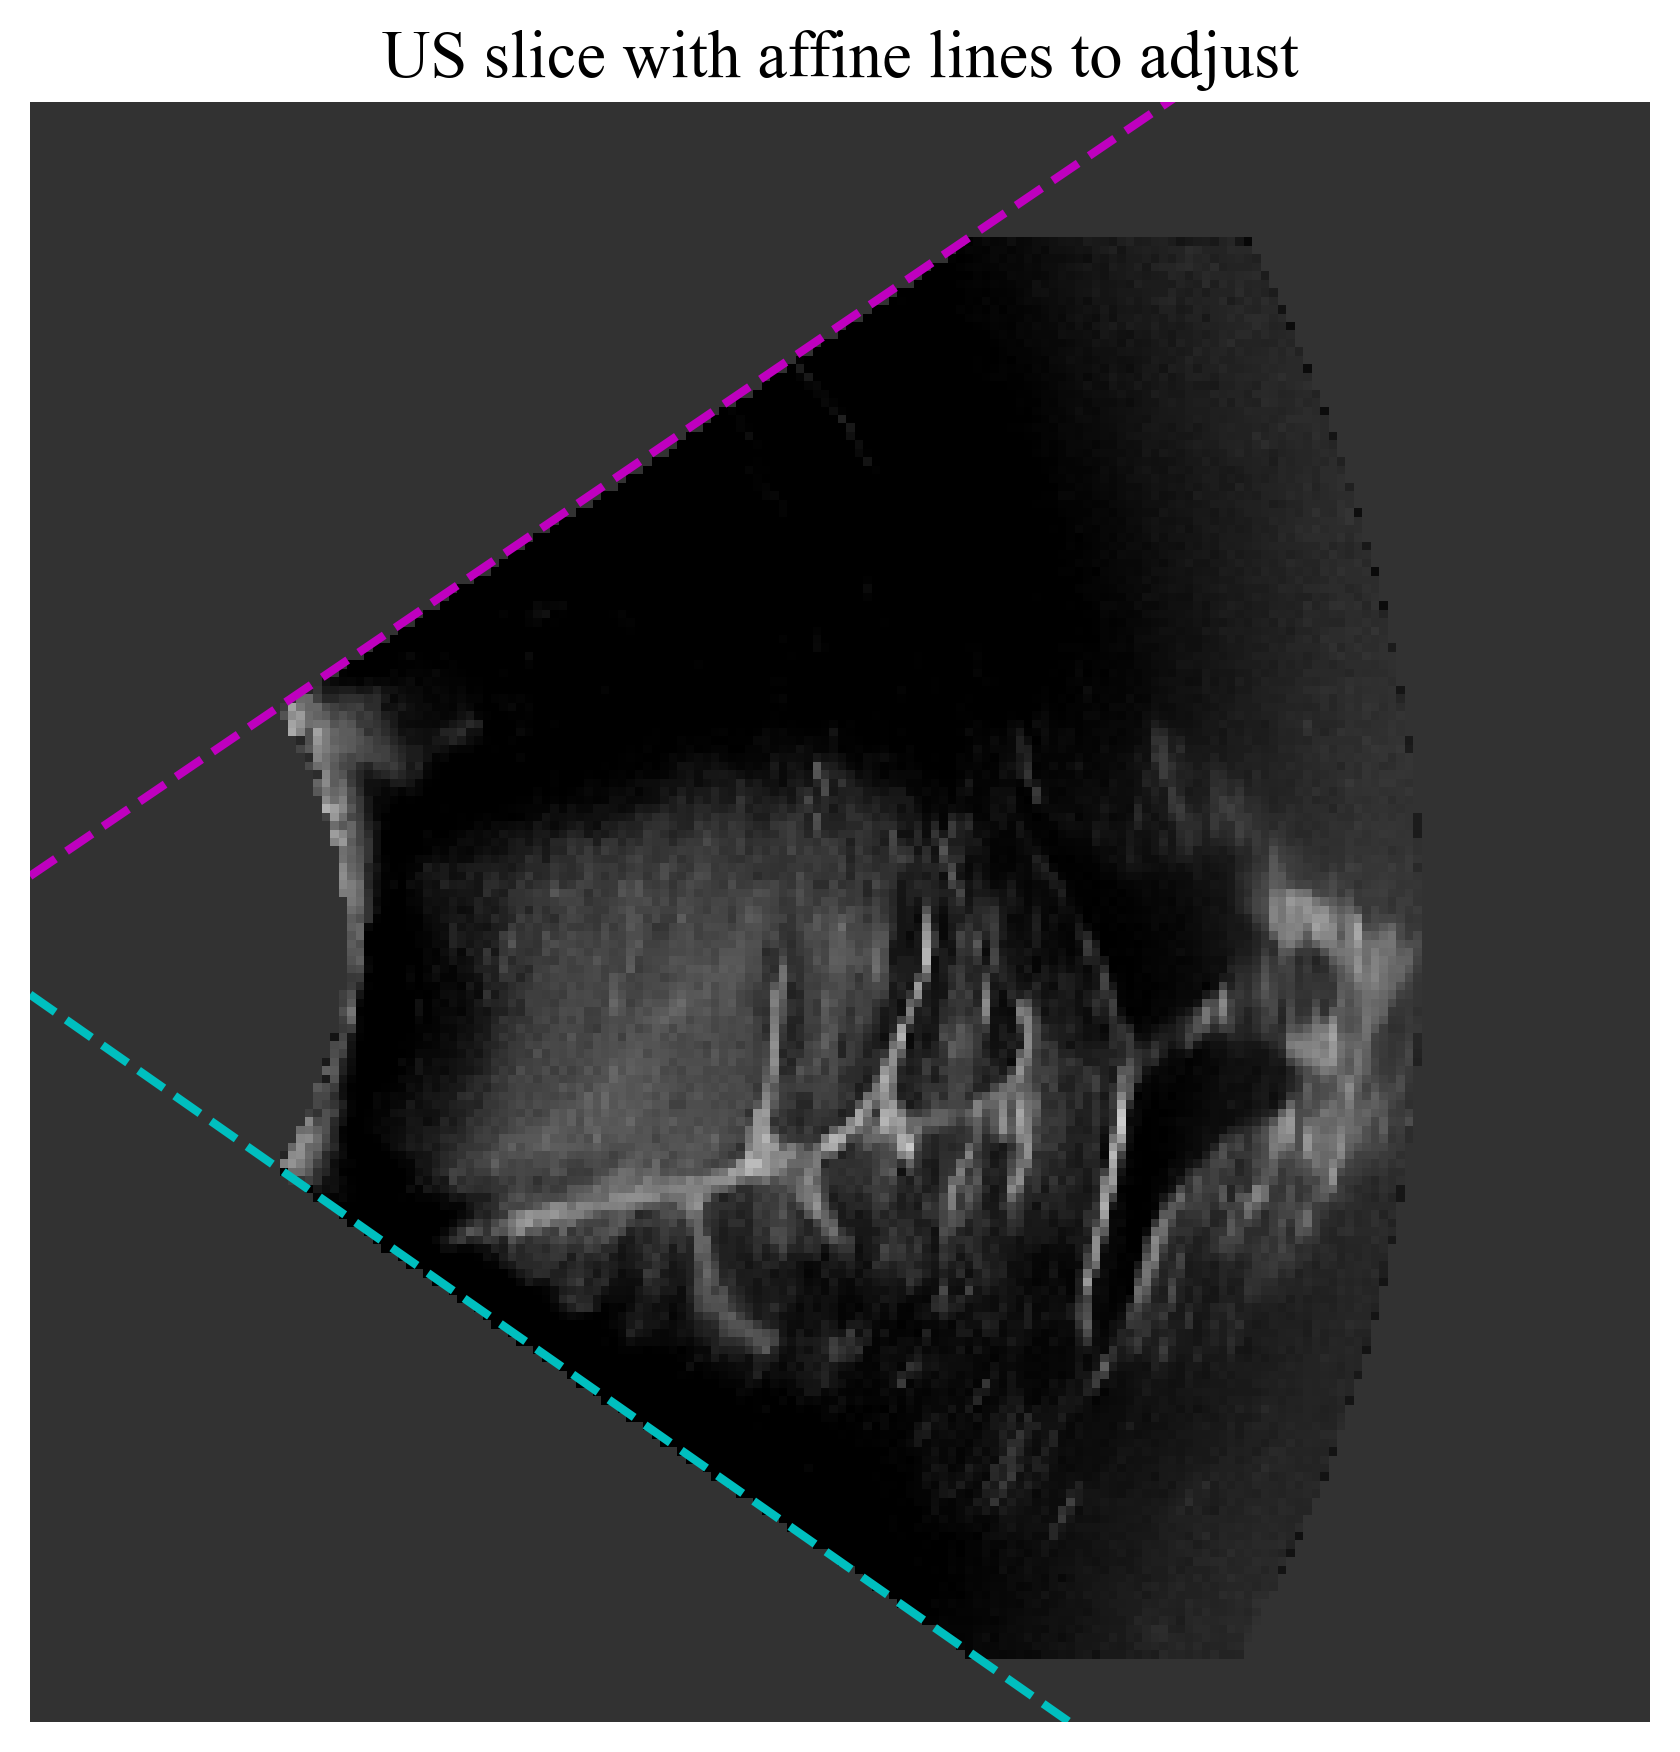

In [9]:
# US edges parameters
mL, bL = -0.7, 86  # Left edge line parameters (slope, intercept)
mR, bR = 0.68, 100  # Right edge line parameters (slope, intercept)
# mL, bL = -0.1, 216
# mR, bR = 1.05, -117
plot_us_with_affine_lines(us_slice, mL, bL, mR, bR)

_, _, k_us = us_idx
H_us, W_us = us_slice.shape

In [10]:
cone_params = compute_us_apex_and_direction(mL, bL, mR, bR)
x0, y0 = cone_params["apex"]
print("Source :", (x0, y0))
opening_angle   = cone_params["opening_angle"]
direction_vec   = cone_params["direction_vector"][::-1]
print("Direction vector :", direction_vec)

Source : (-10.144927536231885, 93.10144927536231)
Direction vector : [0.99997705 0.0067746 ]


(-10.144927536231885, 93.10144927536231) [0.99997705 0.0067746 ] (np.float64(37.85397096577428), np.float64(93.42663013905297)) (np.float64(163.85107953354049), np.float64(94.28022990624093))
[-10.14492754  93.10144928  70.        ] [0.99997705 0.0067746 ]


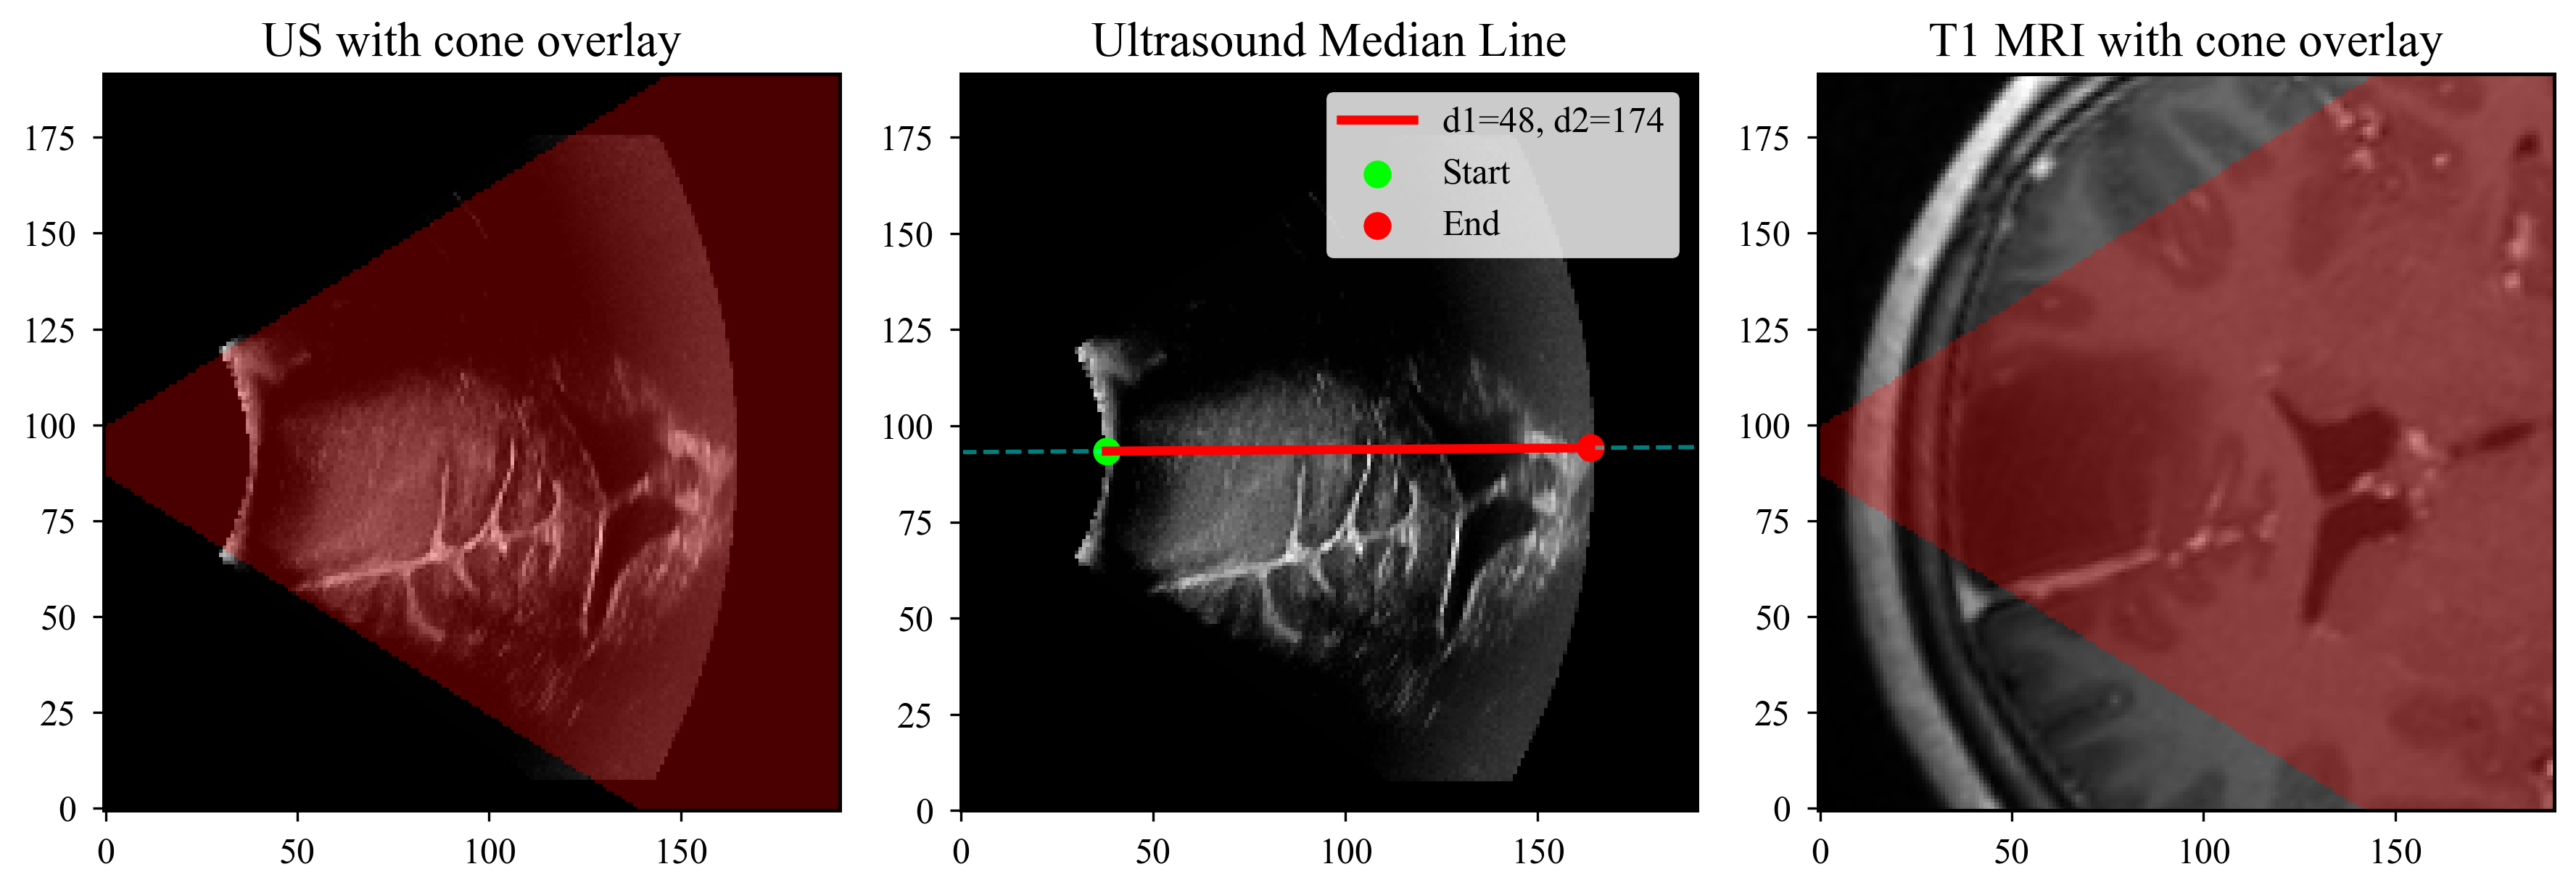

In [11]:
# Correct orientation for overlay_cone and direction vectors
# For US, ensure apex and direction are in (row, col) = (y, x) order
mask_us = overlay_cone(
    us_slice,
    apex=np.array([x0,y0]),  # (row, col)
    direction_vector=[1,0],  # do not reverse, keep as is
    opening_angle=opening_angle / 2 +0.15
)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
plot_overlay_cone(us_slice, mask_us, ax=ax[0], title="US with cone overlay")

plot_median_line(
    us_slice,
    cone_params["apex"],  # (x0, y0)
    direction_vec,
    d1=48, d2=174,
    ax=ax[1]
)

t1_slice = T1_vol[:, :, slice_idx]
apex_us_vox = np.array([x0, y0, k_us])  # (x, y, z) in voxel space

# Convert apex and direction to MRI world coordinates
apex_mri_world, direction_mri_world = cone_us_to_mri_world(
    apex_us_vox,
    direction_vec,
    US_affine,
    T1_affine
)
print(apex_mri_world, direction_mri_world)
# For MRI, apex and direction are in (row, col) = (y, x) order
mask_mri = overlay_cone(
    t1_slice,
    apex=apex_mri_world[:2],  # (row, col)
    direction_vector=direction_mri_world,
    opening_angle=opening_angle / 2 +0.15
)
plot_overlay_cone(t1_slice, mask_mri, ax=ax[2], title="T1 MRI with cone overlay")

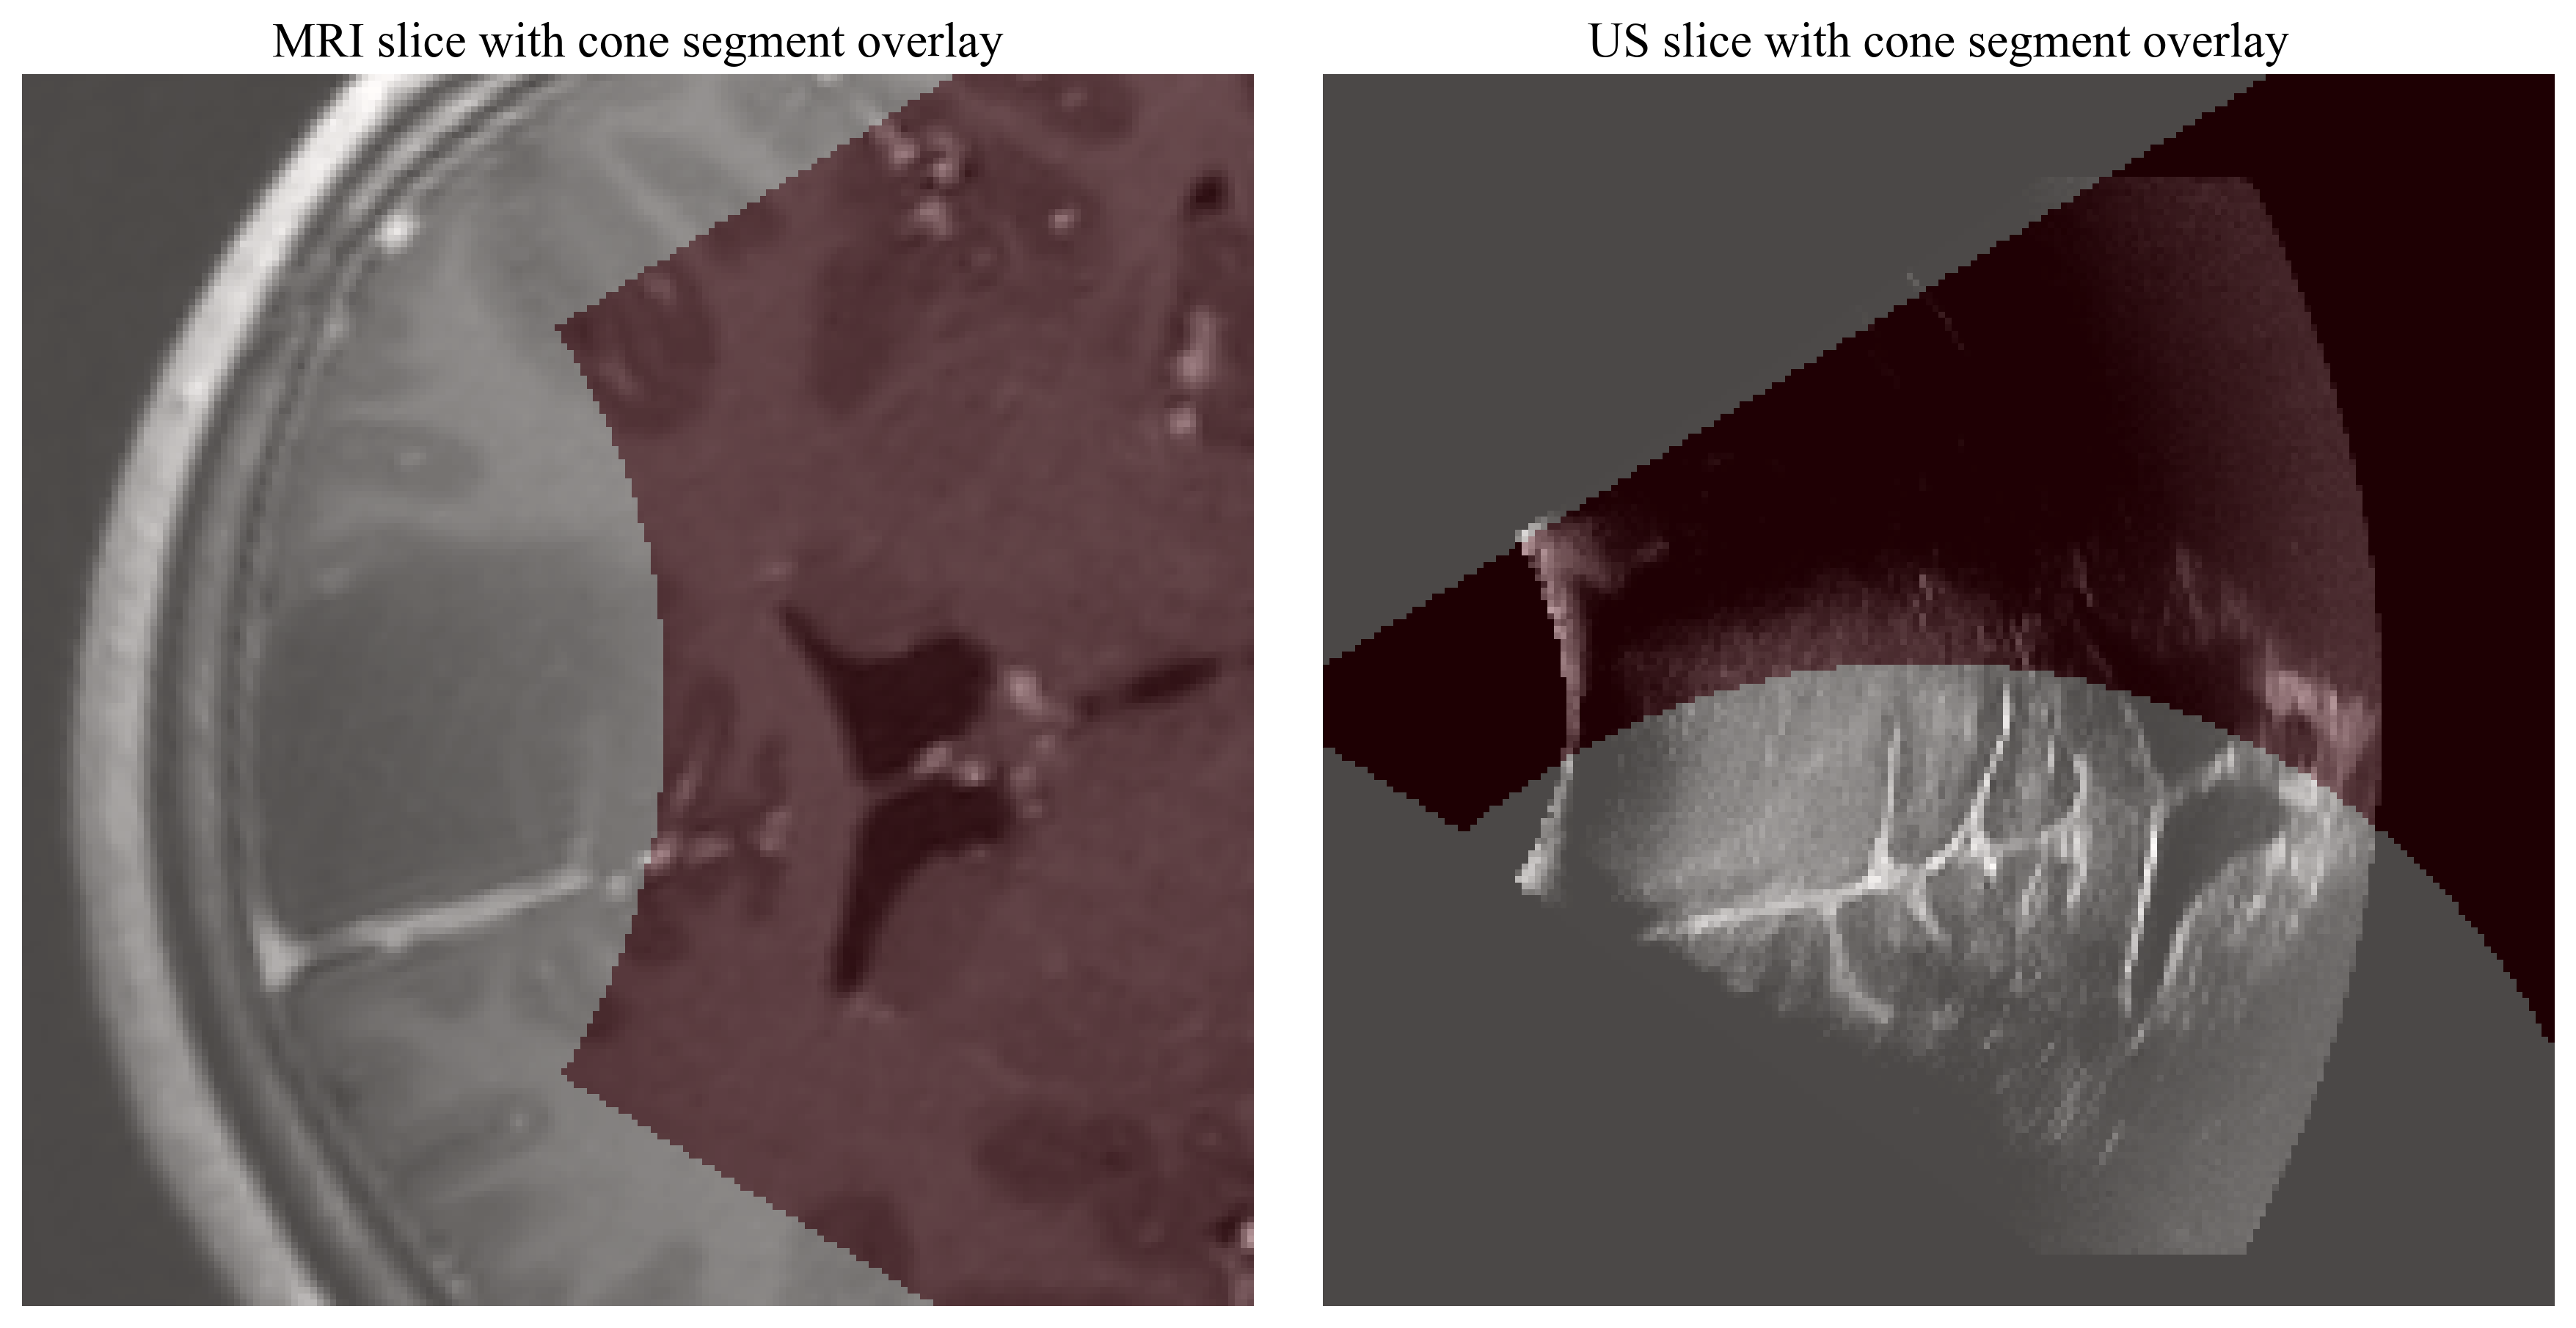

In [12]:
import numpy as np

#rounded version
def mask_cone_segment(mask, apex, direction, d1, d2):
    """
    Keep only the part of the cone between distances d1 and d2 from the apex along the median direction,
    with rounded caps at d1 and d2.
    
    Parameters:
        mask: 2D boolean array (the cone mask)
        apex: (x0, y0) coordinates (float)
        direction: (dx, dy) unit vector (float)
        d1, d2: distances from apex (float)
        
    Returns:
        mask_segment: 2D boolean array with rounded cone segment
    """
    H, W = mask.shape
    x0, y0 = apex
    # Coordinate grid
    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    # Vector from apex to each point
    vx = xx - x0
    vy = yy - y0

    # Calculate distance from apex to each point
    dist = np.sqrt(vx**2 + vy**2)
    # Create a mask for points within the rounded caps

    rounded_mask_d1 = dist >= d1
    rounded_mask_d2 = dist <= d2
    # Combine the masks
    mask = mask & (rounded_mask_d1 | rounded_mask_d2)
    return mask & rounded_mask_d1 & rounded_mask_d2


apex = apex_mri_world[:2]
direction = direction_mri_world[:2][::-1]
d1, d2 = 110, 230

mask_segment_mri = mask_cone_segment(mask_mri, apex, direction, d1, d2)
mask_segment_us = mask_cone_segment(mask_us, np.array([y0,x0]), direction_vec, d1, d2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(t1_slice, cmap='gray', origin='lower')
axs[0].imshow(mask_segment_mri, cmap='Reds', alpha=0.3, origin='lower')
axs[0].set_title("MRI slice with cone segment overlay")
axs[0].axis('off')

axs[1].imshow(us_slice, cmap='gray', origin='lower')
axs[1].imshow(mask_segment_us, cmap='Reds', alpha=0.3, origin='lower')
axs[1].set_title("US slice with cone segment overlay")
axs[1].axis('off')

plt.tight_layout()
plt.show()


# Train MLP to find Z_vol (Acoustic Impedance)

C:\Users\noe\AppData\Local\Temp\ipykernel_64368\3061504502.py:28: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



[INFO] Tracing rays with source: tensor([ 93.1014, -10.1449,  70.0000], dtype=torch.float64) and directions shape: torch.Size([256, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=749.4811, y=2290.6414, z=0.0000


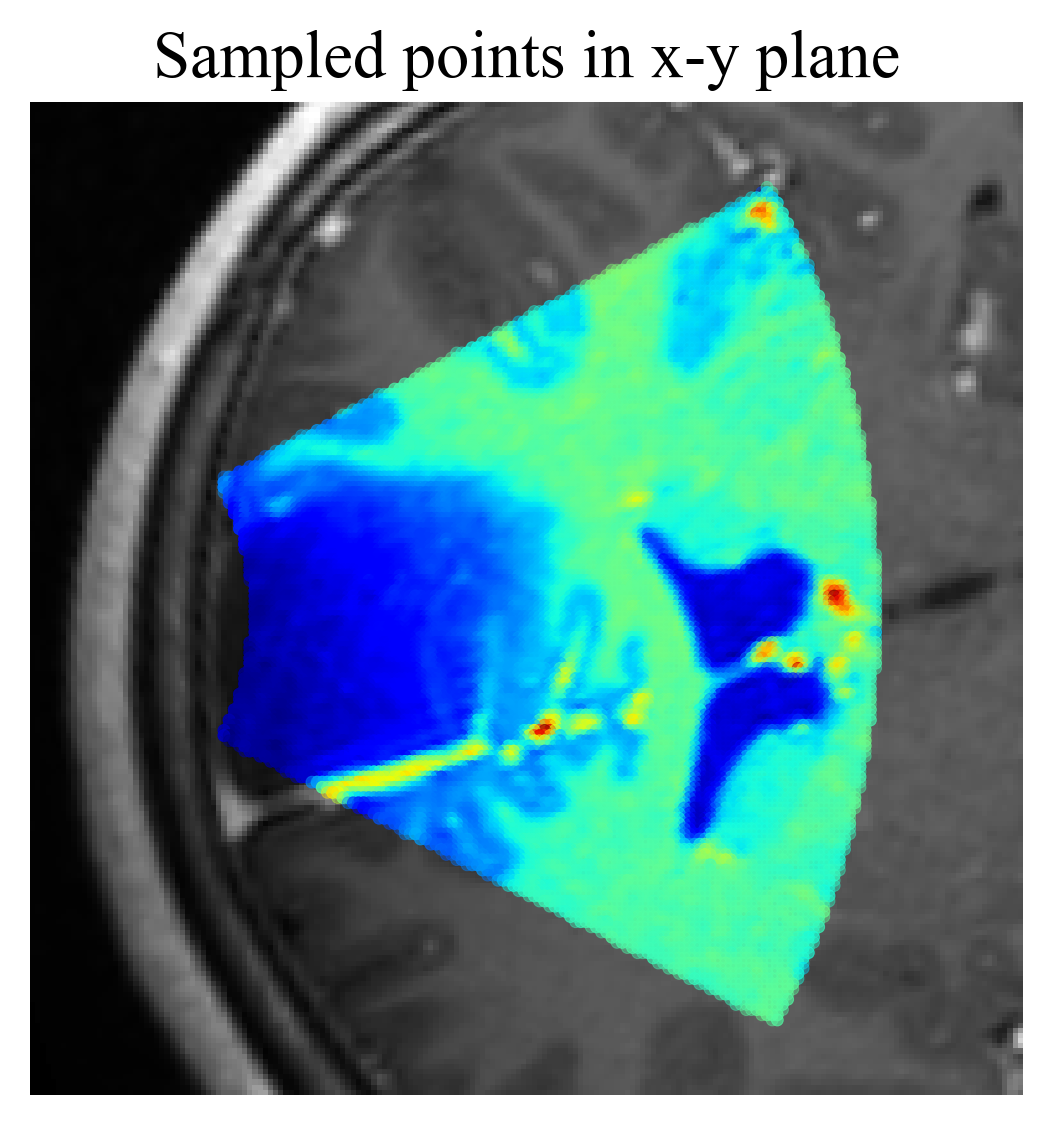

[INFO] Ray values shape: torch.Size([256, 174])
[INFO] Starting from sample index: 53 (for instance, to skip bones)
[INFO] Processed output shape: torch.Size([256, 121])
[INFO] Variances: [1047.7872314453125, 1143.90234375, 0.0]
tensor(0.) tensor(1.4956)


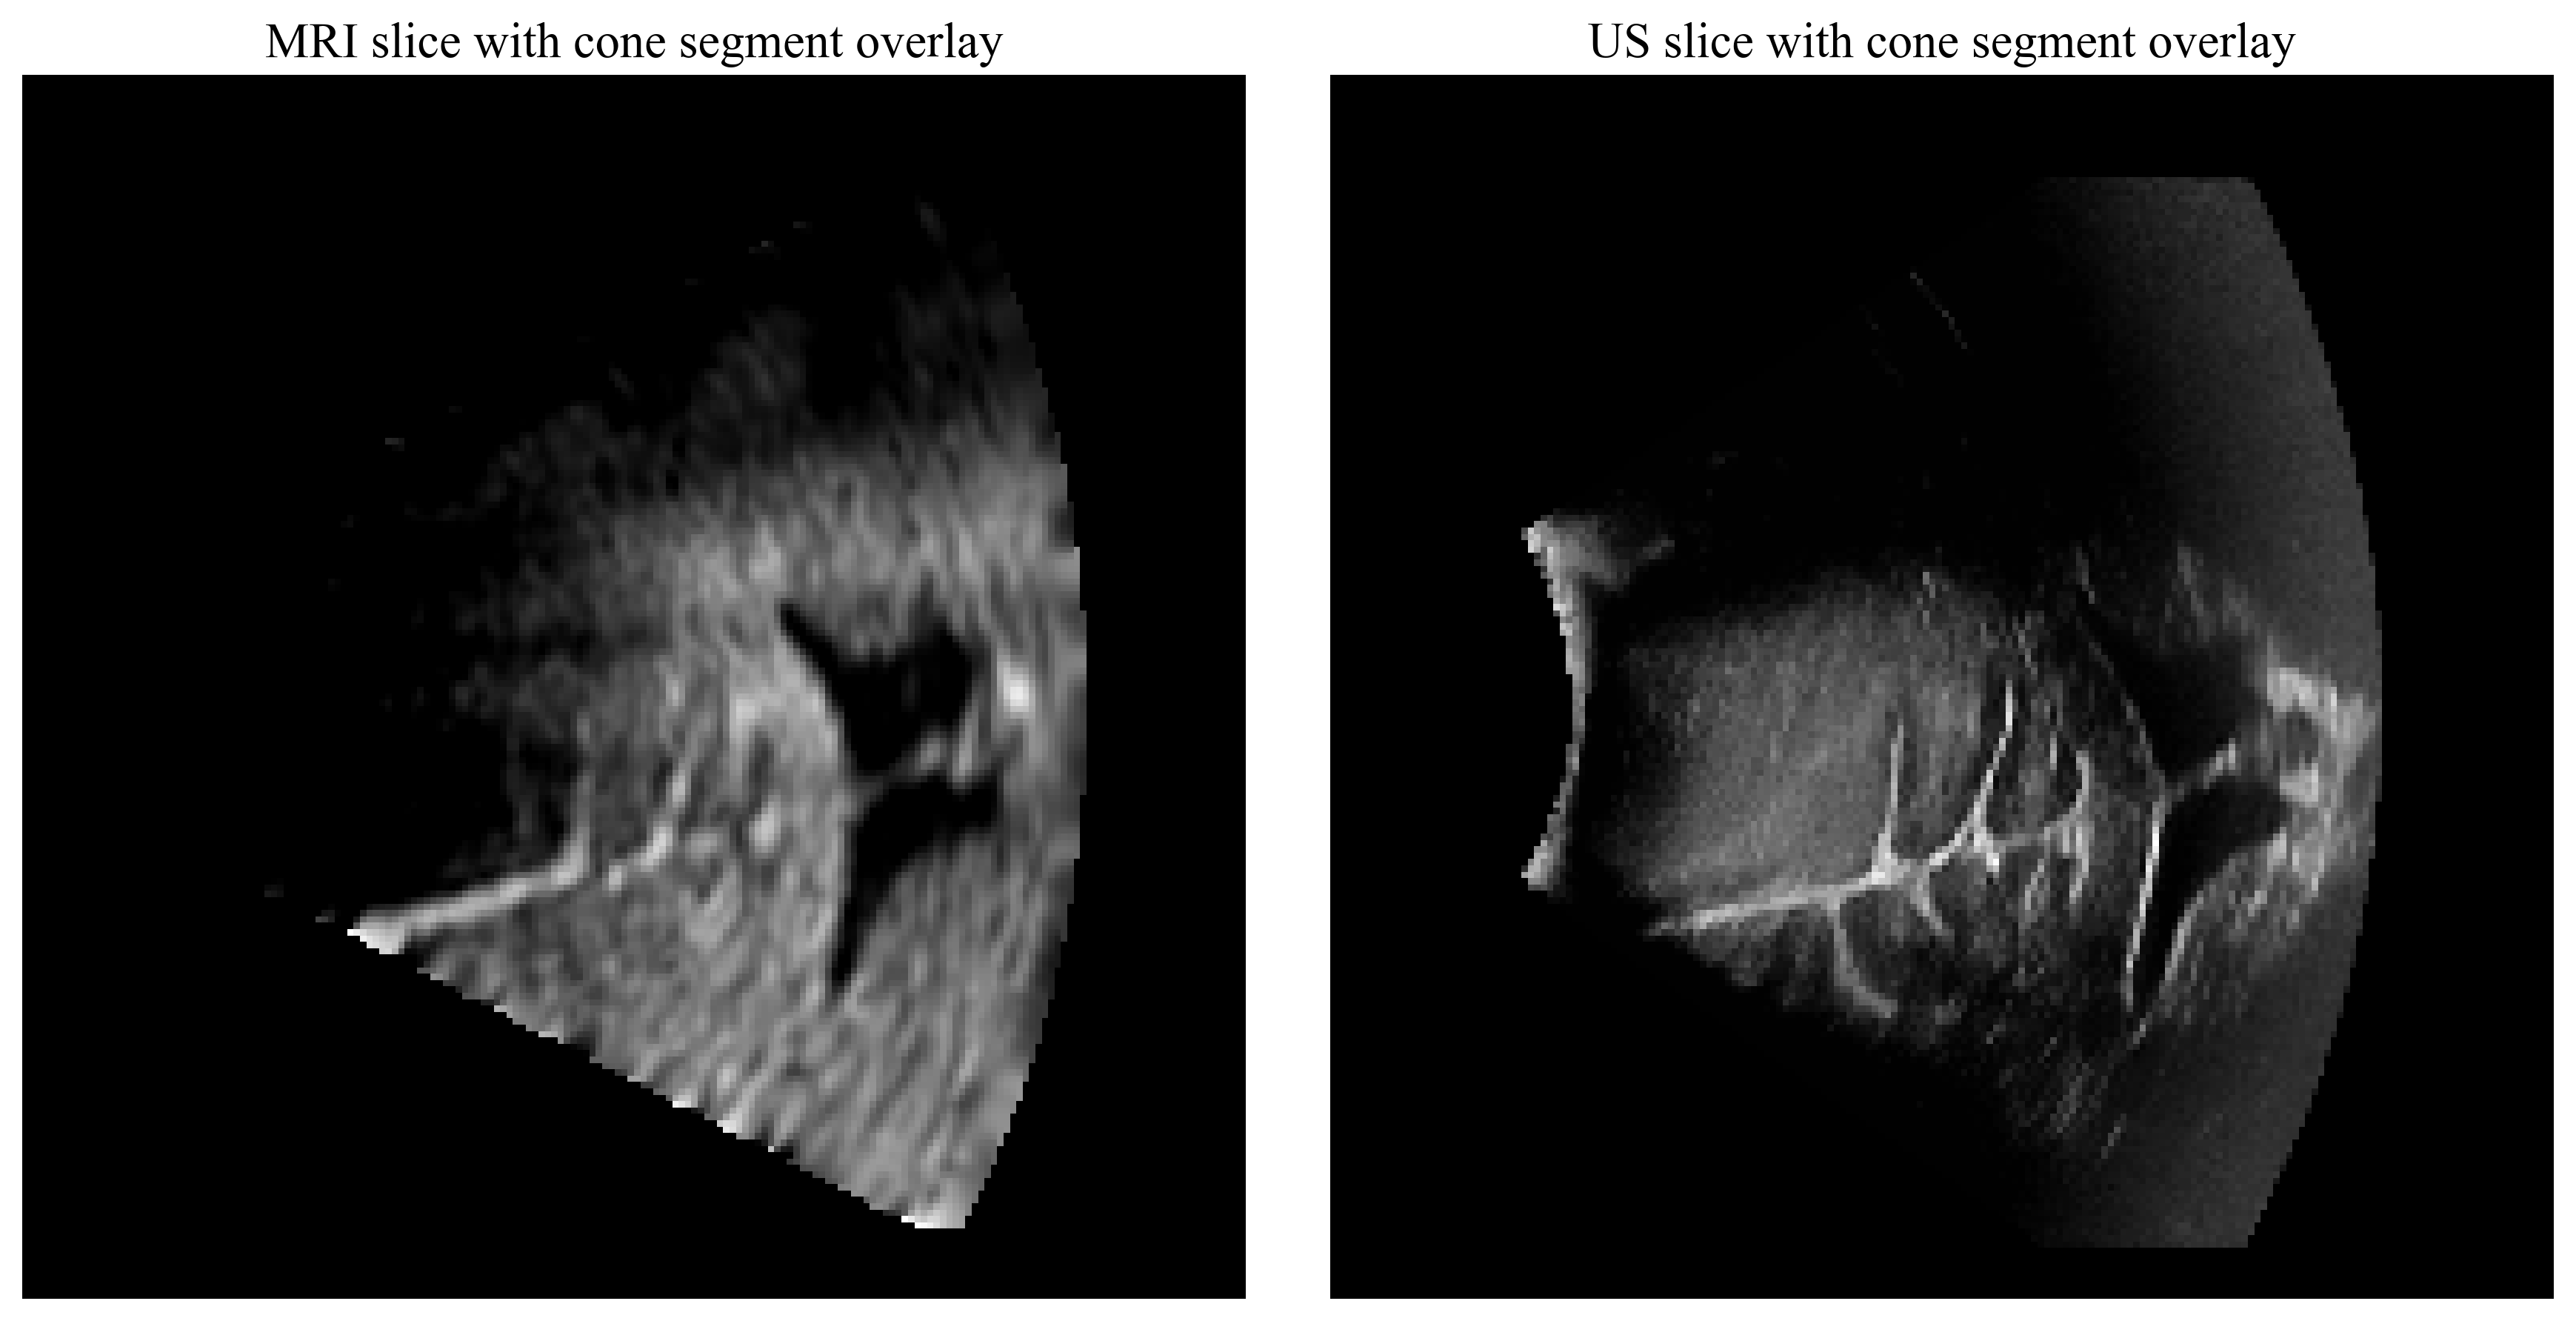

In [14]:
renderer = UltrasoundRenderer(num_samples=174, attenuation_coeff=0.0001)
# Paramètres géométriques
n_rays = 256
source = torch.tensor(apex_mri_world)
H,W = us_slice.shape
def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world[:2])
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([v[0], v[1], 0.0])
    return torch.tensor(directions, dtype=torch.float32)

directions = generate_cone_directions(direction_mri_world[::-1], opening_angle/2, n_rays)
# Z_vol_base = model_one.forward(torch.tensor(T1_vol))
x,y,z, intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vol),
            source=source[[1,0,2]],
            directions=directions,
            angle=np.degrees(opening_angle)/2-5,
            plot=True,
            artifacts=True,
            start=53,
            max_sigma=4
        )
output = differentiable_splat(x, y, z, 
                     intensities, 
                     H=H, W=W, 
                     sigma=1)
print(output.min(), output.max())

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 15})
axs[0].imshow(output.T, cmap='gray', origin='lower', vmin=0.3 )
axs[0].set_title("MRI slice with cone segment overlay")
axs[0].axis('off')

axs[1].imshow(us_slice, cmap='gray', origin='lower')
axs[1].set_title("US slice with cone segment overlay")
axs[1].axis('off')
plt.tight_layout()
plt.show()

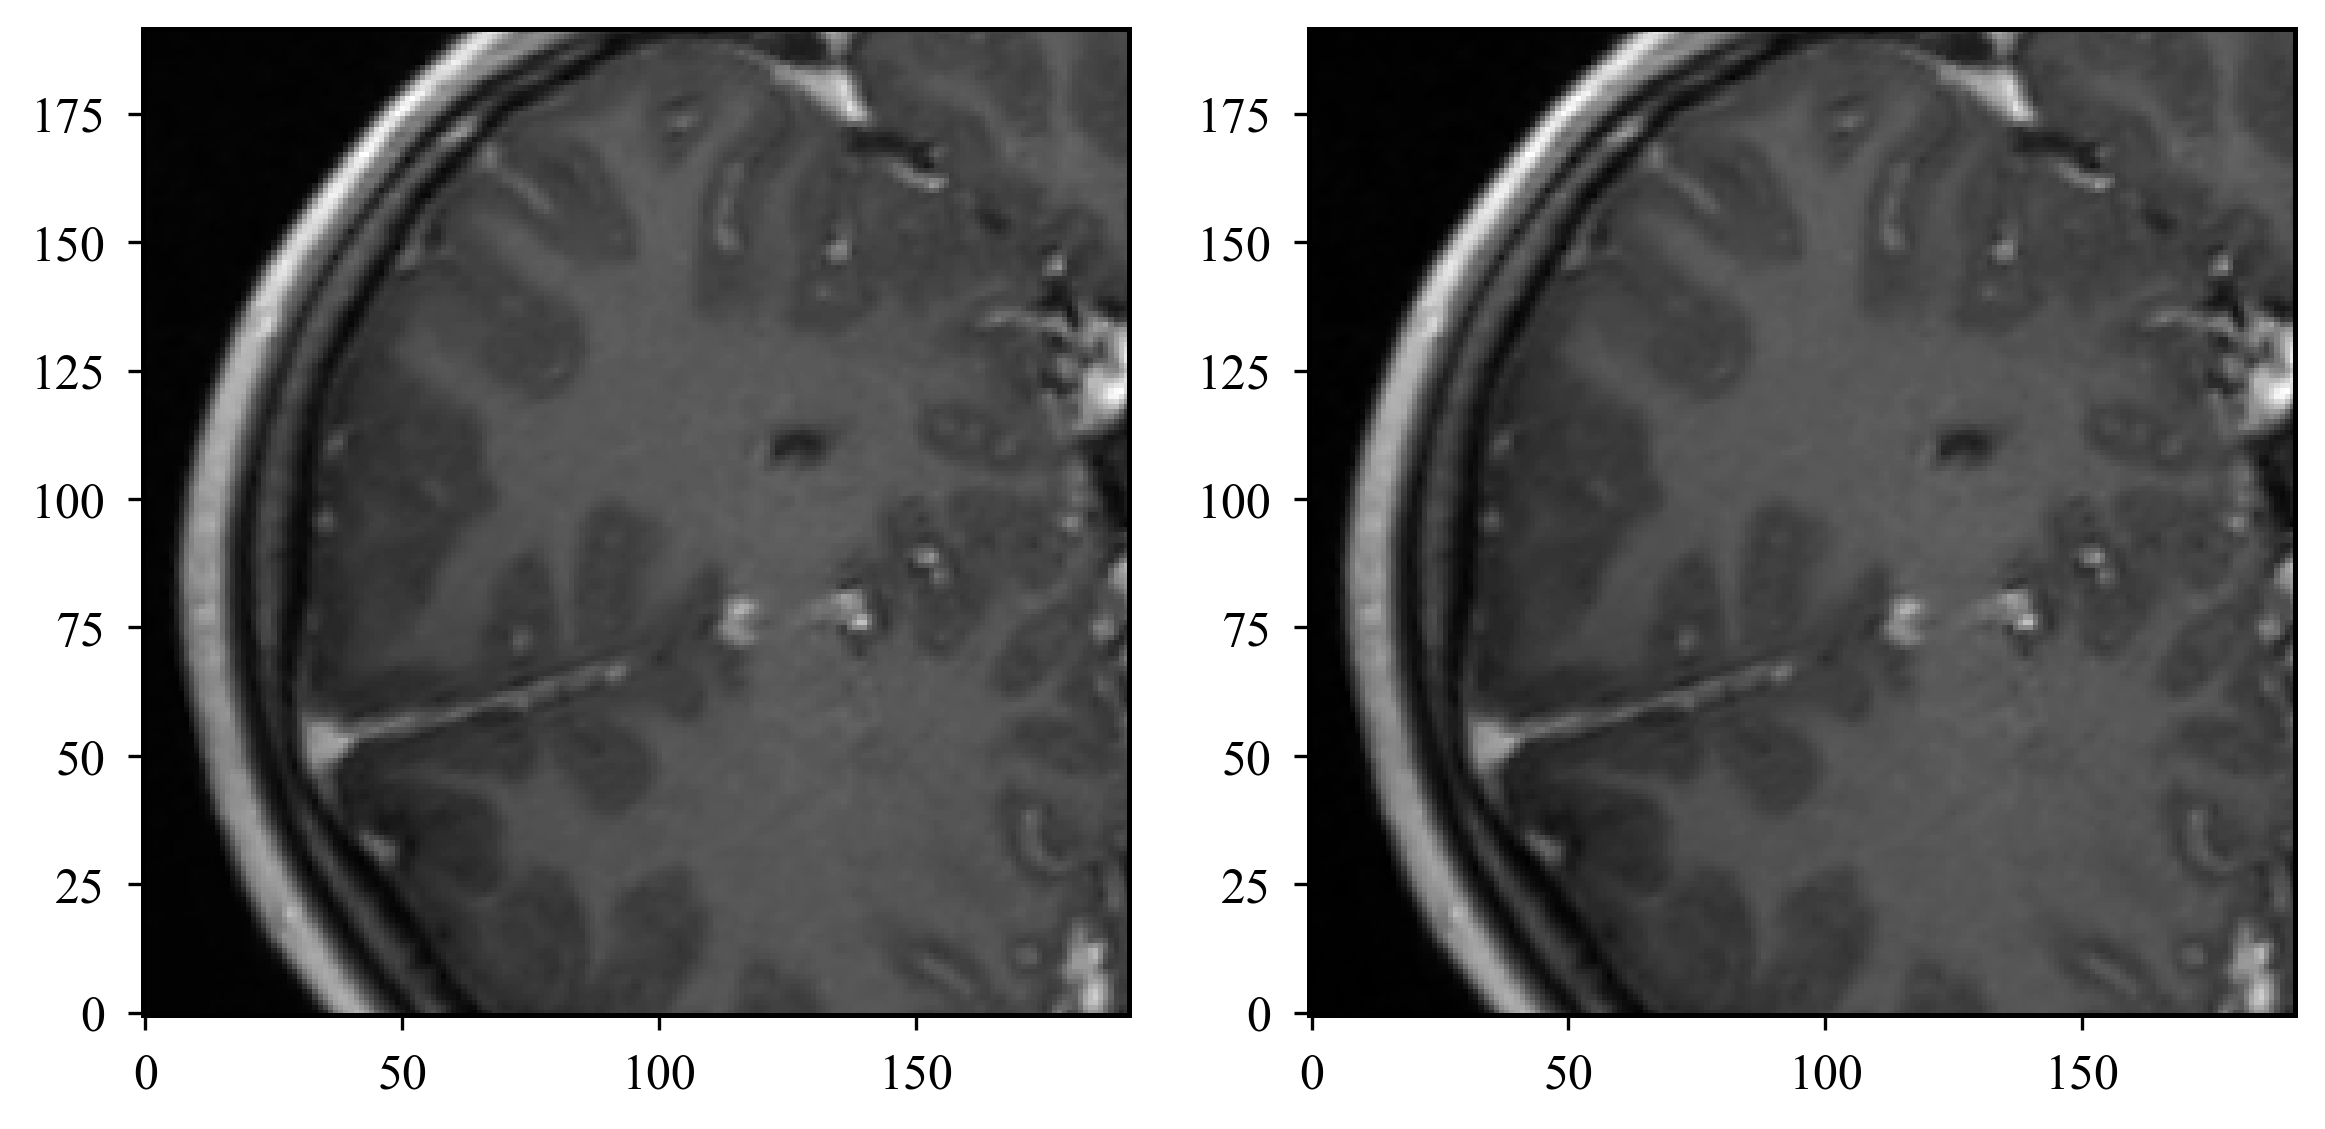

In [32]:
fig, ax = plt.subplots(1,2, figsize=(8, 6))
ax[0].imshow(Z_vol[:,:,130], cmap='gray', origin='lower', vmin=0.3)
ax[1].imshow(T1_vol[:,:,130], cmap='gray', origin='lower', vmin=0.3)

In [ ]:
x,y,z, intensities = renderer.plot_beam_frame(
            volume=torch.tensor(Z_vol),
            source=source[[1,0,2]],
            directions=directions,
            angle=np.degrees(opening_angle)/2-5,
            plot=True,
            artifacts=True,
            start=53,
            max_sigma=4
        )

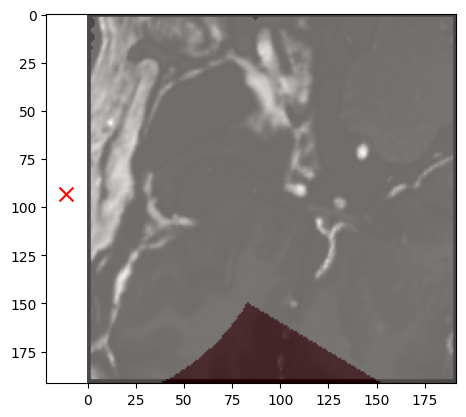

In [75]:
plt.imshow(Z_vol[:, :, 130], cmap='gray')
plt.imshow(mask_segment_mri, cmap='Reds', alpha=0.3)
plt.scatter(
    apex_mri_world[0], 
    apex_mri_world[1], 
    c='red', s=100, label='Apex', marker='x'
)
